In [1]:
import pandas as pd
import numpy as np
import re
import os

import seaborn as sns
import networkx as nx
from community import community_louvain
from operator import itemgetter

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.pyplot as plt

In [2]:
df_corpus = pd.read_json('corpus.json.bz2', compression = 'bz2')
df_corpus['journal'] = df_corpus['journal'].astype('category')
df_corpus.index = np.arange(len(df_corpus))

corpus_text = ''

for ind, row in df_corpus.iterrows():
    corpus_text += row['text']

In [3]:
def keywords_count(df, keywords):
    """ Select text that contains certain keywords and count the latter 
    
    Inputs:
        df(pandas DataFrame): contains all articles in the 'text' column
        keywords(list<str>): list of keywords to search
        
    Output:
        counts(list<list<int>>): count of all keywords in all articles
    """
    
    counts, k = [], []
    
    for keyword in keywords:
        k.append(keyword.lower())
    
    for ind, row in df.iterrows():
        
        counts_ = []
        for k_ in k:
            counts_.append(len(re.findall(k_, row['text'].lower())))
        
        counts.append(counts_)
                
    return counts

In [4]:
entities = [['opep'], ['lausanne'], ['genève'], ['zurich'], ['bâle'], ['ocde'],
           ['ahmed', 'zaki', 'yamani'], ['caracas', 'venezuela'],
           ['riyad', 'ryad', 'arabie', 'saoudite'],
           ['jérusalem'], ['israël'], ['aviv'], ['liban', 'beyrouth'],
           ['bagdad', 'irak'], ['egypte', 'caire'], ['italie', 'rome'],
           ['france', 'paris'], ['valéry', 'giscard', 'estaing'],
           ['bretagne', 'londres', 'royaume-uni'],
           ['danemark'], ['urss','moscou'], ['onu'], ['kippour'], ['kissinger'],
           ['ford', 'gerald'], ['washington', 'états-unis', 'etats-unis', 'USA'], 
           ['portugal'], ['fmi'], ['rfa', 'allemagne', 'berlin'],
           ['tesco'], ['exxon'], ['bp', 'petroleum'], ['texaco'], ['esso'],
           ['michelin'], ['mitsui'], ['gulf'], ['amoco'], ['philips'],
           ['general', 'motors'], ['chrysler'], ['nixon'], ['alger', 'algérie'],
           ['sinaï'], ['indonésie'], ['espagne', 'madrid'], ['téhéran', 'iran'],
           ['jimmy', 'carter'], ['abou', 'dhabi', 'emirats'], ['koweït'],
           ['ocde'], ['norvège'], ['khomeny'], ['qatar'], ['sadate'], ['syrie'],
           ['gabon'], ['nigeria'], ['équateur'], ['chávez'],
           ['europe', 'cee', 'bruxelles', 'ceca', 'strasbourg'],
           ['olp', 'palestine']]

names = [['OPEP'], ['Lausanne'], ['Genève'], ['Zurich'], ['Bâle'], ['OCDE'],
           ['Yamani'], ['Venezuela'],
           ['Arabie saoudite'],
           ['Jérusalem'], ['Israël'], ['Tel Aviv'], ['Liban'],
           ['Irak'], ['Egypte'], ['Italie'],
           ['France'], ['Giscard d\'Estaing'],
           ['Royaume-uni'],
           ['Danemark'], ['URSS'], ['ONU'], ['Kippour'], ['Kissinger'],
           ['G. Ford'], ['USA'], 
           ['Portugal'], ['FMI'], ['RFA'],
           ['Tesco'], ['Exxon'], ['BP'], ['Texaco'], ['Esso'],
           ['Michelin'], ['Mitsui'], ['Gulf Oil'], ['Amoco'], ['Philips'],
           ['General motors'], ['Chrysler'], ['Nixon'], ['Algérie'],
           ['Sinaï'], ['Indonésie'], ['Espagne'], ['Iran'],
           ['Carter'], ['Emirats arabes'], ['Koweït'],
           ['OCDE'], ['Norvège'], ['Khomeny'], ['Qatar'], ['Sadate'], ['Syrie'],
           ['Gabon'], ['Nigeria'], ['Equateur'], ['Chávez'],
           ['Europe'],
           ['Palestine']]

In [5]:
def csv_to_graph(path):
    
    df_corpus = pd.read_csv(path)
    df = df_corpus[['journal', 'date', 'page', 'ppage', 'text']]
    
    for i in range(len(entities)):
        counts = keywords_count(df, entities[i])
        counts = np.asarray(counts).T
        df[names[i][0]] = counts[0]
        for j in range(1, counts.shape[0]):
             df[names[i][0]] += counts[j]
                
    df = df.drop(columns = ['journal', 'date', 'page', 'ppage', 'text'])
    
    array = pd.DataFrame(np.zeros(len(df.columns)), df.columns)
    for tag in df.columns:
        array[tag] = np.zeros(len(df.columns))
    array = array.drop(columns = 0)
    
    for ind, row in df.iterrows():
        tags = row[row > 1]
        for col1 in tags.index:
            for col2 in tags.index:
                array[col1][col2] += 1
                array[col2][col1] += 1
    
    G = nx.Graph()
    G.add_nodes_from(array.columns)
    
    list_edges = []

    for ind, row in array.iterrows():
        for column in array.columns:
            if row[column] > 0.:
                list_edges.append((ind, column, row[column]/2.))
    
    G.add_weighted_edges_from(list_edges)
    
    betweenness = nx.betweenness_centrality(G)
    nx.set_node_attributes(G, betweenness, 'betweenness')
    sorted_betweenness = sorted(betweenness.items(), key=itemgetter(1), reverse=True)
    
    return sorted_betweenness

In [6]:
DATA = 'corpus_by_year/'
folder = os.listdir(DATA)  

folder_ = []
for file in folder:
    if (file[0] != '.') & (file[0] != '_'):
        folder_.append(file)
folder = folder_

In [7]:
folder

['1979_corpus.csv',
 '1974_corpus.csv',
 '1971_corpus.csv',
 '1976_corpus.csv',
 '1973_corpus.csv',
 '1981_corpus.csv',
 '1978_corpus.csv',
 '1975_corpus.csv',
 '1972_corpus.csv',
 '1980_corpus.csv',
 '1977_corpus.csv']

In [8]:
sorted_betweennesses = []

for file in folder:
    sorted_betweennesses.append(csv_to_graph(DATA + file))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [9]:
tags = []

for element in sorted_betweennesses[0]:
    tags.append(element[0])

In [10]:
dico = {}
for tag in tags:
    dico[tag] = []

In [11]:
for i in range(len(folder)):
    for j in range(len(tags)):
        element = sorted_betweennesses[i][j]
        tag = element[0]
        dico[tag].append(element[1])

In [12]:
index = [1979, 1974, 1971, 1976, 1973, 1981, 1978, 1975, 1972, 1980, 1977]
df_betweenness = pd.DataFrame(dico, index = index).sort_index()

In [13]:
sns.set(rc={'figure.figsize':(30,10)})
sns.set_style("ticks")
sns.set_context('notebook', font_scale=2)

In [14]:
sorted_betweennesses[-1]

[('USA', 0.06740919998968223),
 ('Arabie saoudite', 0.03907252732874552),
 ('France', 0.03496597020971266),
 ('Genève', 0.032099153606145785),
 ('Carter', 0.027900538907343054),
 ('Europe', 0.0235833717882309),
 ('URSS', 0.01997222619238151),
 ('RFA', 0.018514391555181465),
 ('Italie', 0.017242290039381224),
 ('Esso', 0.014502168593644164),
 ('Egypte', 0.012855791968453982),
 ('Royaume-uni', 0.012456355584296322),
 ('Liban', 0.010613798335632828),
 ('Israël', 0.010084978568606634),
 ('Zurich', 0.009657669622380754),
 ('Emirats arabes', 0.008256741796539072),
 ('BP', 0.0052806591491851495),
 ('Irak', 0.004600739920438719),
 ('Iran', 0.00448037041672801),
 ('OPEP', 0.003994903832059034),
 ('Syrie', 0.003544477797967329),
 ('Indonésie', 0.0029749163173888996),
 ('Yamani', 0.002569540933199956),
 ('Qatar', 0.002276939623649494),
 ("Giscard d'Estaing", 0.002158150952600936),
 ('Venezuela', 0.0021011233698172887),
 ('Koweït', 0.0019859240609489863),
 ('Espagne', 0.001843009510008513),
 ('Jér

In [17]:
color_list = ['#A71D05',
              '#00559C',
              '#885AB8','#936ABF', '#9D78C5',
              '#559C00', '#66A519', '#75AE2F', '#82B643', '#8EBD55',
              '#5BAF96', '#6BB7A0', '#88C5B3',
              '#A51951',
              '#A57C19', '#AE892F', '#B69443', '#BD9E55', '#C3A766', '#C9AF75']
colormap = ListedColormap(color_list)

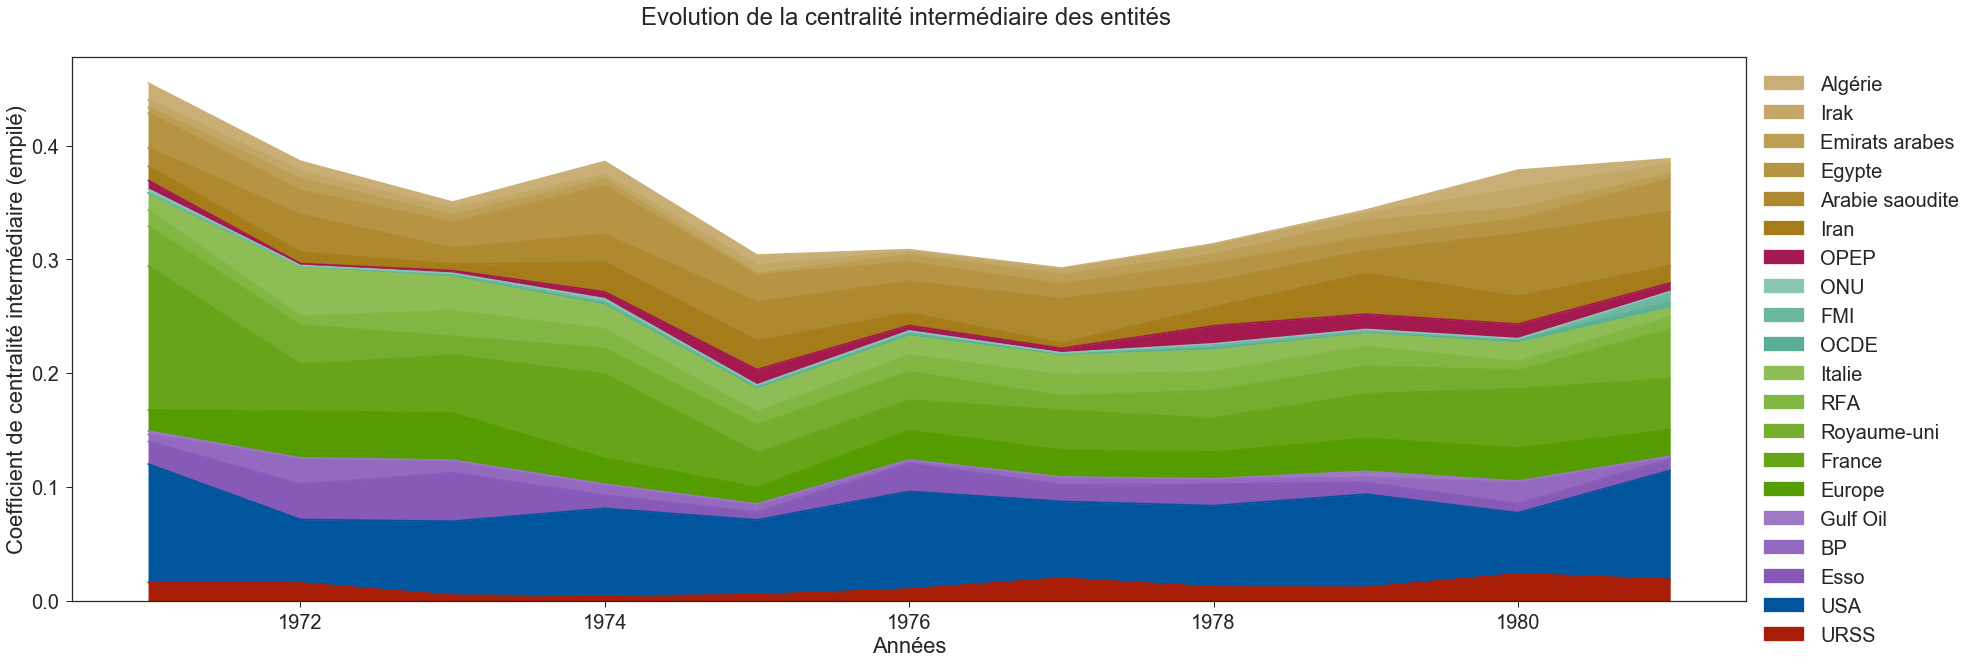

In [18]:
ax = df_betweenness.plot(y = ['URSS',
                              'USA',
                              'Esso', 'BP', 'Gulf Oil',
                              'Europe', 'France', 'Royaume-uni', 'RFA', 'Italie',
                              'OCDE', 'FMI', 'ONU',
                              'OPEP',
                              'Iran', 'Arabie saoudite', 'Egypte', 'Emirats arabes', 'Irak', 'Algérie'],
                         title = 'Evolution de la centralité intermédiaire des entités \n',
                         kind ='area', colormap = colormap)
ax.set_ylabel('Coefficient de centralité intermédiaire (empilé)')
ax.set_xlabel('Années')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1, 1))

In [ ]:
color_list = ['#9C0007',
              '#00559C', '#3276AF',
              '#559C00', '#66A519', '#75AE2F', '#82B643', '#8EBD55',
              '#A51966',
              '#A57C19', '#AE892F', '#B69443', '#BD9E55', '#C3A766']
colormap = ListedColormap(color_list)

In [ ]:
ax = df_betweenness.plot(legend= 'reverse', y = ['URSS',
                                                 'USA', 'Carter', 
                                                 'Europe', 'France', 'Royaume-uni', 'RFA', 'Italie',
                                                 'OPEP', 
                                                 'Iran', 'Arabie saoudite', 'Egypte', 'Emirats arabes',
                                                    'Venezuela'],
                         title = 'Evolution de la centralité intermédiaire des entités \n',
                         kind ='area', colormap = colormap)
ax.set_ylabel('Coefficient de centralité intermédiaire')
ax.set_xlabel('Années')

In [7]:
len(corpus_text)

68571621

In [8]:
len(entities)

62

In [9]:
df = df_corpus[['journal', 'date', 'page', 'ppage', 'text']]

In [10]:
for i in range(len(entities)):
    counts = keywords_count(df, entities[i])
    counts = np.asarray(counts).T
    df[names[i][0]] = counts[0]
    for j in range(1, counts.shape[0]):
         df[names[i][0]] += counts[j]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [11]:
df.head(1)

,journal,date,page,ppage,text,OPEP,Lausanne,Genève,Zurich,Bâle,...,Khomeny,Qatar,Sadate,Syrie,Gabon,Nigeria,Equateur,Chávez,Europe,Palestine
0,JDG,1974-01-07,2,NaN,"Pétrole : "" (déjà 50000 la crise continue chôm...",5,0,2,0,0,...,0,0,0,0,0,1,0,0,1,0


In [12]:
df = df.drop(columns = ['journal', 'date', 'page', 'ppage', 'text'])

In [13]:
df.to_csv('entities.csv')

In [14]:
array = pd.DataFrame(np.zeros(len(df.columns)), df.columns)

In [15]:
for tag in df.columns:
    array[tag] = np.zeros(len(df.columns))

array = array.drop(columns = 0)

In [16]:
len(df)

21139

In [17]:
array

,OPEP,Lausanne,Genève,Zurich,Bâle,OCDE,Yamani,Venezuela,Arabie saoudite,Jérusalem,...,Khomeny,Qatar,Sadate,Syrie,Gabon,Nigeria,Equateur,Chávez,Europe,Palestine
OPEP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Lausanne,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Genève,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zurich,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bâle,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OCDE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Yamani,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Venezuela,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Arabie saoudite,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Jérusalem,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
for ind, row in df.iterrows():
    tags = row[row > 1]
    for col1 in tags.index:
        for col2 in tags.index:
            array[col1][col2] += 1
            array[col2][col1] += 1

In [19]:
G = nx.Graph()
G.add_nodes_from(array.columns)

In [20]:
list_edges = []

for ind, row in array.iterrows():
    for column in array.columns:
        if row[column] > 0.:
            list_edges.append((ind, column, row[column]/2.))

In [21]:
G.add_weighted_edges_from(list_edges)

In [22]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 61
Number of edges: 1250
Average degree:  40.9836


In [23]:
partition = community_louvain.best_partition(G)

In [30]:
partition = pd.Series(partition)

In [25]:
partition.value_counts()

3     11
0     10
13     7
1      6
2      5
9      4
10     3
6      2
11     2
4      2
5      2
17     1
7      1
16     1
12     1
14     1
15     1
8      1
dtype: int64

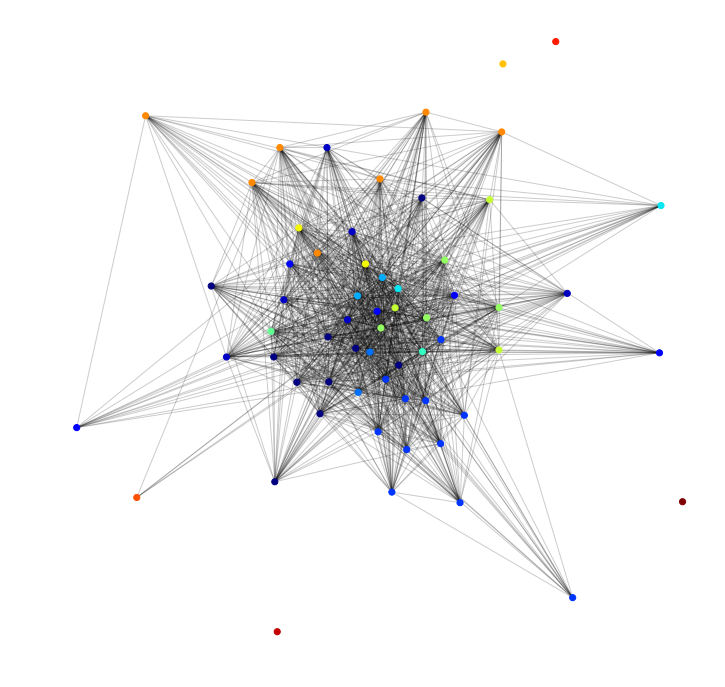

In [26]:
partition = community_louvain.best_partition(G)
# add it as an attribute to the nodes
for n in G.nodes:
    G.nodes[n]["louvain"] = partition[n]
    
# plot it out
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 3)
ec = nx.draw_networkx_edges(G, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(),
                            node_color=[G.nodes[n]["louvain"] for n in G.nodes], 
                            with_labels=True, node_size=150, cmap=plt.cm.jet, node_shape = '.')
plt.axis('off')
plt.show()

In [37]:
partition[partition == 3]

Jérusalem    3
Israël       3
Tel Aviv     3
Liban        3
Egypte       3
Kippour      3
Kissinger    3
Sinaï        3
Sadate       3
Syrie        3
Palestine    3
dtype: int64

In [31]:
partition[partition == 0]

OPEP               0
Yamani             0
Venezuela          0
Arabie saoudite    0
Algérie            0
Indonésie          0
Emirats arabes     0
Koweït             0
Qatar              0
Nigeria            0
dtype: int64

In [32]:
partition[partition == 13]

Exxon             13
BP                13
Texaco            13
Gulf Oil          13
Philips           13
General motors    13
Chrysler          13
dtype: int64

In [33]:
partition[partition == 1]

Lausanne    1
Genève      1
Zurich      1
Bâle        1
Danemark    1
Norvège     1
dtype: int64

In [34]:
partition[partition == 2]

OCDE                 2
France               2
Giscard d'Estaing    2
Michelin             2
Gabon                2
dtype: int64

In [35]:
partition[partition == 9]

G. Ford    9
USA        9
Nixon      9
Carter     9
dtype: int64

In [36]:
partition[partition == 10]

Portugal    10
Espagne     10
Europe      10
dtype: int64

In [38]:
betweenness = nx.betweenness_centrality(G) # Run betweenness centrality
# Assign each to an attribute in your network
nx.set_node_attributes(G, betweenness, 'betweenness')
sorted_betweenness = sorted(betweenness.items(), key=itemgetter(1), reverse=True)
sorted_betweenness

[('France', 0.016693024854278603),
 ('USA', 0.016693024854278603),
 ('Arabie saoudite', 0.015299331763374512),
 ('G. Ford', 0.011478142052056373),
 ('Egypte', 0.010082855362753178),
 ('Italie', 0.008877486188986561),
 ('Genève', 0.008803565635845778),
 ('Royaume-uni', 0.008320065421997137),
 ('Iran', 0.008320065421997137),
 ('Emirats arabes', 0.007482931881225827),
 ('Europe', 0.006951182737259382),
 ('Esso', 0.005869803641991454),
 ('Carter', 0.00584281532286544),
 ('RFA', 0.005723254078662205),
 ('OPEP', 0.004527052214569503),
 ('Exxon', 0.004446383838418049),
 ('Zurich', 0.004257942920065733),
 ('URSS', 0.004248330696959163),
 ('Lausanne', 0.003773054155540377),
 ('Espagne', 0.0037648059127959868),
 ('Kissinger', 0.003716914062016215),
 ('Algérie', 0.0036188478533411236),
 ('ONU', 0.0035810309602001826),
 ('Israël', 0.0035404977452877023),
 ('Syrie', 0.0033233116199847643),
 ('General motors', 0.0032992678116974105),
 ("Giscard d'Estaing", 0.002913996693240804),
 ('Irak', 0.00279865

In [44]:
list_ = []
for entry in sorted_betweenness:
    list_.append(entry[1])
s = pd.Series(list_)

In [70]:
sns.set(rc={'figure.figsize':(15,15)})
sns.set_style("ticks")
sns.set_context('notebook', font_scale=2)

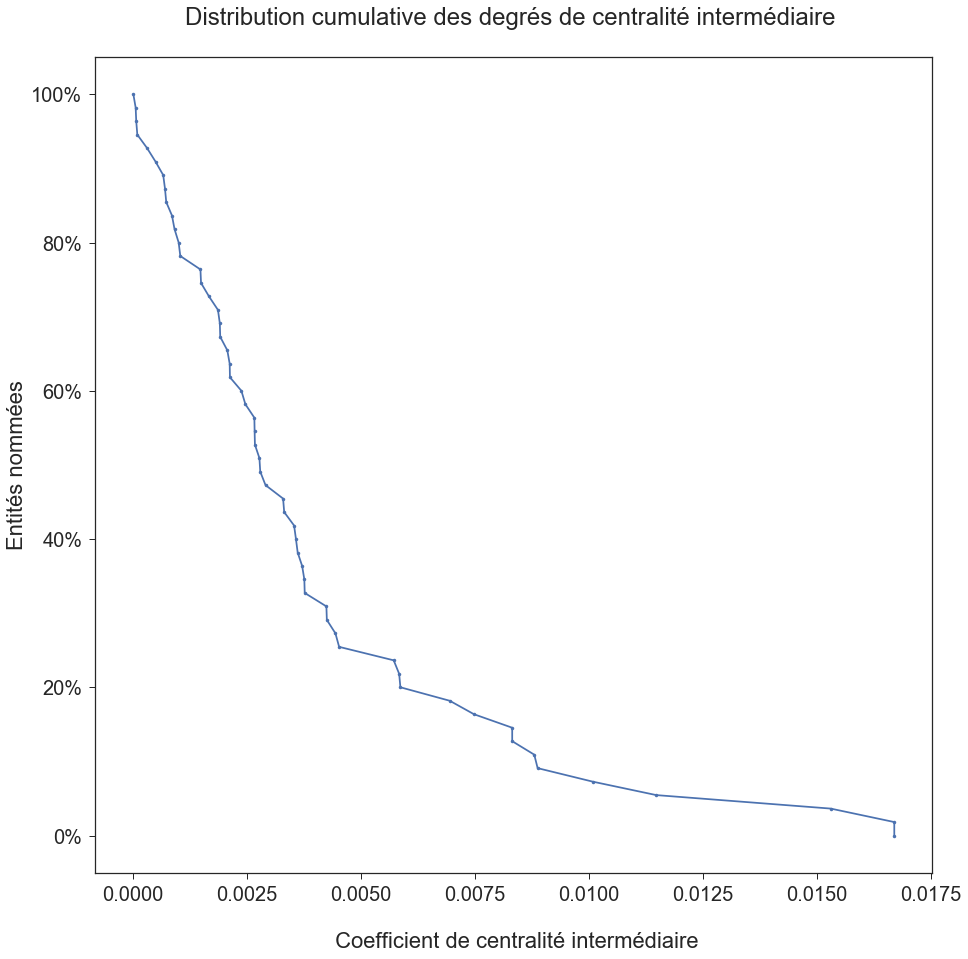

In [72]:
plt.plot(s[:56].values, s[:56].index, '.-')
plt.xlabel('\n Coefficient de centralité intermédiaire')
plt.ylabel('Entités nommées')
plt.yticks(np.linspace(s[:56].index[0], s[:56].index[-1], 6), [
    '0%', '20%', '40%', '60%', '80%', '100%'])
plt.title('Distribution cumulative des degrés de centralité intermédiaire \n')
plt;

In [39]:
nx.transitivity(G)

0.8410656867248507

In [40]:
degrees = dict(G.degree(G.nodes()))
sorted_degree = sorted(degrees.items(), key=itemgetter(1), reverse=True)
sorted_degree

[('France', 58),
 ('USA', 58),
 ('Arabie saoudite', 57),
 ('Egypte', 57),
 ('Genève', 56),
 ('Italie', 56),
 ('Royaume-uni', 56),
 ('Iran', 56),
 ('Europe', 55),
 ('RFA', 54),
 ('Esso', 54),
 ('URSS', 53),
 ('Emirats arabes', 53),
 ('OPEP', 52),
 ('G. Ford', 52),
 ('Zurich', 51),
 ('Algérie', 51),
 ('Carter', 51),
 ('Irak', 50),
 ('Yamani', 49),
 ('Israël', 49),
 ('Kissinger', 49),
 ('Venezuela', 48),
 ('BP', 48),
 ('Espagne', 48),
 ('Koweït', 48),
 ('Syrie', 48),
 ("Giscard d'Estaing", 47),
 ('Lausanne', 46),
 ('Liban', 46),
 ('ONU', 46),
 ('FMI', 46),
 ('OCDE', 43),
 ('General motors', 43),
 ('Nixon', 43),
 ('Portugal', 42),
 ('Nigeria', 42),
 ('Gulf Oil', 41),
 ('Norvège', 41),
 ('Palestine', 41),
 ('Sadate', 40),
 ('Exxon', 39),
 ('Jérusalem', 38),
 ('Chrysler', 38),
 ('Qatar', 38),
 ('Indonésie', 37),
 ('Bâle', 36),
 ('Texaco', 36),
 ('Sinaï', 35),
 ('Danemark', 34),
 ('Tel Aviv', 32),
 ('Gabon', 26),
 ('Philips', 24),
 ('Amoco', 22),
 ('Kippour', 18),
 ('Michelin', 16),
 ('Mitsui

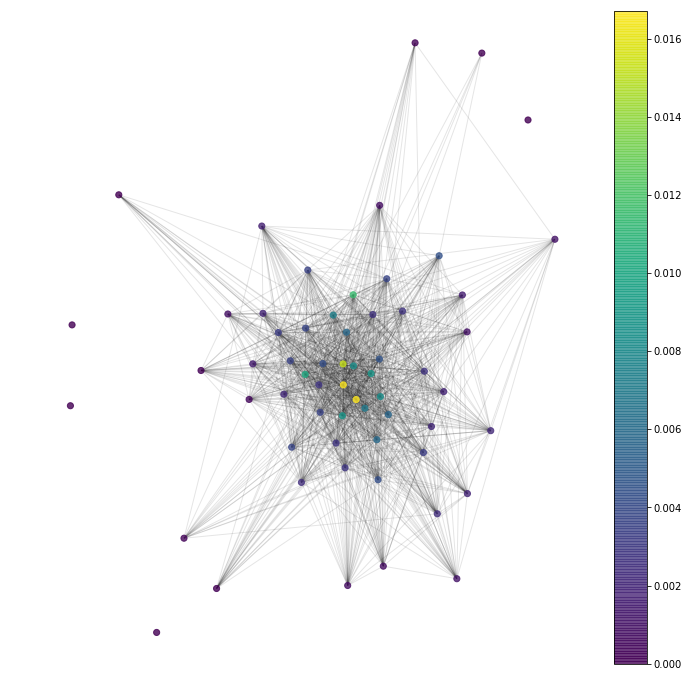

In [42]:
# similar pattern
plt.figure(figsize=(12,12))
list_nodes = list(G.nodes())
list_nodes.reverse()   # for showing the nodes with high betweeness centrality 
pos = nx.spring_layout(G, k = 3)
ec = nx.draw_networkx_edges(G, pos, alpha=0.1)
nc = nx.draw_networkx_nodes(G, pos, nodelist=list_nodes, node_size=150,
                            node_color=[G.nodes[n]["betweenness"] for n in list_nodes], 
                            with_labels=True, alpha=0.8, node_shape = '.')
plt.colorbar(nc)
plt.axis('off')
plt.show()